In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
tf.enable_eager_execution()

In [ ]:
# training parameters 
learning_rate=0.001
training_steps=500
batch_size=32
display_step=20

#network parameters 
num_input_units=80
timesteps= 28*28
num_classes=10
num_hidden_units =200
num_output_units =10


In [ ]:
state=tf.random_uniform(shape=[num_hidden_units,1])

In [ ]:
spike_in=tf.where(tf.greater(tf.random_uniform(shape=[num_input_units,1]),1.0),
                  tf.constant(1.0,shape=[num_input_units,1],dtype=tf.float32),
                              tf.constant(0.0,shape=[num_input_units,1],dtype=tf.float32))

In [ ]:
dt=tf.constant(1.0,dtype=tf.float32)

In [ ]:
 [spike,state]=LIFLayer(num_hidden_units,num_input_units,dt,spike_in,state)

In [ ]:
def OutputLayer(k,j,spike_in,dt,state):
    neurons=k
    inputs=j
    tau_m = 5.0
    # tensor variables 
    V_out = tf.contrib.eager.Variable(tf.constant(0.0,shape=[k,1],dtype=tf.float32),name='V_out')
    W_out = tf.contrib.eager.Variable(tf.random_normal(shape=[k,j],mean=0.0,stddev=0.1,dtype=tf.float32),name='W_out')
    G_out= tf.contrib.eager.Variable(tf.ones(shape=[k,1],dtype=tf.float32),name='G_out')
    
    ## update membrane dynamics 
    dv_out=tf.divide(state,tau_m)
    V_temp=tf.subtract(state,dv_out*dt)
    V_update=tf.clip_by_value(V_temp,tf.constant(0.0,shape=[k,1]),tf.constant(100.0,shape=[k,1]))
    spike_in_float=tf.cast(spike_in,tf.float32)
    spike_temp=tf.transpose(tf.tile(spike_in_float,[1,k]))
    weight_update=tf.multiply(W_out,spike_temp)
    G_update=tf.reduce_sum(weight_update, 1, keepdims=True)
    # not sure about this step
    v_membrane = tf.add(V_update,G_update)
    return v_membrane


In [ ]:
spike_rec=tf.where(tf.greater(tf.random_uniform(shape=[num_hidden_units,1]),0.5),
                  tf.constant(1.0,shape=[num_hidden_units,1],dtype=tf.float32),
                              tf.constant(0.0,shape=[num_hidden_units,1],dtype=tf.float32))
state_out=tf.random_uniform(shape=[num_output_units,1])

In [ ]:
Vout = OutputLayer(num_output_units,num_hidden_units,spike_rec,dt,state_out)


In [ ]:
with tf.GradientTape() as t:
    t.watch(spike_rec)
    Vout = OutputLayer(num_output_units,num_hidden_units,spike_rec,dt,state_out)

dz_dx = t.gradient(Vout, spike_rec) 


In [ ]:
spike_rec=tf.where(tf.greater(tf.random_uniform(shape=[num_hidden_units,1]),0.5),
                  tf.constant(1.0,shape=[num_hidden_units,1],dtype=tf.float32),
                              tf.constant(0.0,shape=[num_hidden_units,1],dtype=tf.float32))
x = tf.random_uniform(shape=[num_output_units,1])
W_o = tf.contrib.eager.Variable(tf.random_normal(shape=[num_output_units,num_hidden_units],mean=0.0,stddev=0.1,dtype=tf.float32))

with tf.GradientTape() as t:
  t.watch(x)
  y=tf.divide(x,5.0)
  z=tf.subtract(x,y*dt)
  z1=tf.clip_by_value(z,tf.constant(0.0,shape=[num_output_units,1]),tf.constant(0.5,shape=[num_output_units,1]))
  z2=tf.cast(z1,tf.float64)
  sp=tf.cast(spike_rec,tf.float32)
  sp1=tf.transpose(tf.tile(sp,[1,num_output_units]))
  w1=tf.multiply(W_o,sp1)
  G_up=tf.reduce_sum(w1, 1, keepdims=True) 
  v_mem = tf.divide(z1,G_up)
# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z2, x)
dz_dx


In [ ]:
state=tf.clip_by_value(tf.add(tf.random_uniform(shape=[num_hidden_units,1]),tf.constant(.5,shape=[num_hidden_units,1])),0,1)

In [ ]:

[spike,state]=LIFLayer(num_hidden_units,num_input_units,dt,spike_in,state)


In [ ]:
with tf.GradientTape() as t:
    t.watch(spike_rec)
    v_update=tf.where(tf.cast(spike_rec,tf.bool),tf.constant(0.0,shape=[num_hidden_units,1],dtype=tf.float32),state)
    v_update1=tf.subtract(state,tf.multiply(spike_rec,tf.constant(1.0,shape=[num_hidden_units,1],dtype=tf.float32)))
    Spike_temp=tf.transpose(tf.tile(spike_rec,[1,num_hidden_units]))
dz_dx = t.gradient(Spike_temp, spike_rec) 
#plt.figure()
#plt.subplot(3,1,1)
#plt.plot(v_update1.numpy())
#plt.subplot(3,1,2)
#plt.plot(v_update.numpy())
#plt.subplot(3,1,3)
#plt.plot(state.numpy())

In [ ]:
def LIFLayer(n,m,dt,Spike_in,state):
    neurons=n
    inputs=m
    tau_m = 5.0
    v_theta = 1.0
    v_reset = 0.0
    tau_s = 5.0
    tau_refract = 3.0
    # tensor variables 
    V = tf.contrib.eager.Variable(tf.constant(0.0,shape=[n,1],dtype=tf.float32),name='V')
    Spike = tf.contrib.eager.Variable(tf.constant(v_reset,shape=[n,1],dtype=tf.float32),name='Spike')
    W_rec = tf.contrib.eager.Variable(tf.random_normal(shape=[n,n],mean=1.0,stddev=0.1,dtype=tf.float32),name='W_rec')
    W_in = tf.contrib.eager.Variable(tf.random_normal(shape=[n,m],mean=1.0,stddev=0.1,dtype=tf.float32),name='W_in')
    G=tf.contrib.eager.Variable(tf.ones(shape=[n,1],dtype=tf.float32),name='G')
    S=tf.contrib.eager.Variable(tf.zeros(shape=[n,n],dtype=tf.float32),name='S')
    G_in=tf.contrib.eager.Variable(tf.ones(shape=[n,1],dtype=tf.float32),name='G_in')
    S_in=tf.contrib.eager.Variable(tf.zeros(shape=[n,m],dtype=tf.float32),name='S_in')
    I_syn=tf.contrib.eager.Variable(tf.ones(shape=[n,1],dtype=tf.float32),name='I_syn')
    t_reset=tf.contrib.eager.Variable(tf.ones(shape=[n,1],dtype=tf.float32),name='t_reset')
    
    # subfunctions 
    @tf.custom_gradient
    def calculate_crossing_op(x):
        x_norm=tf.divide(tf.subtract(x,tf.constant(v_theta,shape=[n,1])),
                         tf.constant(v_theta,shape=[n,1]))
        temp=tf.greater_equal(x,tf.constant(v_theta,shape=[n,1],dtype=tf.float32))
        def grad(dy):            
            return tf.maximum(tf.constant(0.0,dtype=tf.float32),tf.subtract(tf.constant(1.0,dtype=tf.float32),tf.abs(x_norm)))  
        return tf.cast(temp,tf.float32), grad

    ## spiking neuron dynamics 
    Spike=calculate_crossing_op(state)
    v_update=tf.subtract(state,tf.multiply(tf.cast(Spike,tf.float32),tf.constant(v_theta,shape=[n,1],dtype=tf.float32)))
    ## update conductance for recurrent spikes 
    dS_op=tf.divide(S,tau_s)
    dS_in_op=tf.divide(S_in,tau_s)
    S_temp=tf.subtract(S,dS_op*dt)
    S_in_temp=tf.subtract(S_in,dS_in_op*dt)
    S_op=tf.clip_by_value(S_temp,tf.constant(0.0,shape=[n,n]),tf.constant(100.0,shape=[n,n]))
    S_in_op=tf.clip_by_value(S_in_temp,tf.constant(0.0,shape=[n,m]),tf.constant(100.0,shape=[n,m]))
    Spike_op_float=tf.cast(Spike,tf.float32)
    Spike_in_op_float=tf.cast(Spike_in,tf.float32)
    Spike_ax=tf.clip_by_value(tf.subtract(tf.transpose(tf.tile(Spike_op_float,[1,n])),
                                            tf.eye(n,dtype=tf.float32)),0.0,100.0)

    Spike_in_temp=tf.transpose(tf.tile(Spike_in_op_float,[1,n]))
    Spike_in_ax=Spike_in_temp
    S_update= tf.add(S,Spike_ax)
    S_in_update=tf.add(S_in,Spike_in_ax)
    G_op=tf.reduce_sum(tf.multiply(W_rec,S_update), 1, keepdims=True)
    G_in_op=tf.reduce_sum(tf.multiply(W_in,S_in_update), 1, keepdims=True)
    I_input=tf.add(tf.multiply(G_op,v_update),tf.multiply(G_in_op,v_update))
    ## update voltages
    # find neurons in refractory 
    t_subtract= tf.subtract(t_reset,tf.constant(1.0,shape=[n,1]))
    t_margin=tf.clip_by_value(t_subtract,0.0,100)
    t_reset_update=tf.add(t_margin,tf.multiply(Spike,tf.constant(v_theta,shape=[n,1],dtype=tf.float32)))
    eligilible_update=tf.cast(tf.equal(t_reset_update,tf.constant(0.0,shape=[n,1])),tf.float32)
    # update voltage
    dV_op=tf.add(tf.constant(v_reset,shape=[n,1],dtype=tf.float32),tf.multiply(eligilible_update,
                                                                               tf.divide(tf.subtract(I_input,v_update),tau_m)))
    V_out=tf.add(v_update,tf.multiply(dV_op,dt))
    return Spike, v_update
        

In [ ]:
[spike,state]=LIFLayer(num_hidden_units,num_input_units,dt,spike_in,state)

In [ ]:
def test_gradient(x,n):
    @tf.custom_gradient
    def calculate_crossing_op(x):
        x_norm=tf.divide(tf.subtract(x,tf.constant(1.0,shape=[n,1])),tf.constant(1.0,shape=[n,1]))
        temp=tf.greater_equal(x,tf.constant(1.0,shape=[n,1],dtype=tf.float32))
        def grad(dy):            
            return tf.maximum(tf.constant(0.0,dtype=tf.float32),tf.subtract(tf.constant(1.0,dtype=tf.float32),tf.abs(x_norm)))  
        return tf.cast(temp,tf.float32), grad
    z = calculate_crossing_op(x)
    return z 

x = tf.reshape(tf.linspace(-10.0, 10.0, 300, name="linspace"),shape=[300,1])
with tf.GradientTape() as t:
    t.watch(x)
    z = test_gradient(x,300)

dz_dx = t.gradient(z, x) 
plt.figure(figsize=[15,10])
plt.plot(x.numpy().flatten(),z.numpy().flatten())
plt.plot(x.numpy(),dz_dx.numpy())

In [ ]:
def test_gradient(x,Spike_in,n,m):
    tau_m = 5.0
    v_theta = 1.0
    v_reset = 0.0
    tau_s = 5.0
    tau_refract = 3.0
    S=tf.contrib.eager.Variable(tf.zeros(shape=[n,n],dtype=tf.float32),name='S')
    S_in=tf.contrib.eager.Variable(tf.zeros(shape=[n,m],dtype=tf.float32),name='S_in')
    W_rec = tf.contrib.eager.Variable(tf.random_normal(shape=[n,n],mean=0.0,stddev=0.1,dtype=tf.float32),name='W_rec')
    W_in = tf.contrib.eager.Variable(tf.random_normal(shape=[n,m],mean=1.0,stddev=0.1,dtype=tf.float32),name='W_in')
    t_reset=tf.contrib.eager.Variable(tf.ones(shape=[n,1],dtype=tf.float32),name='t_reset')
    @tf.custom_gradient
    def calculate_crossing_op(x):
        x_norm=tf.divide(tf.subtract(x,tf.constant(1.0,shape=[n,1])),tf.constant(1.0,shape=[n,1]))
        temp=tf.greater_equal(x,tf.constant(1.0,shape=[n,1],dtype=tf.float32))
        def grad(dy):            
            return tf.maximum(tf.constant(0.0,dtype=tf.float32),tf.subtract(tf.constant(1.0,dtype=tf.float32),tf.abs(x_norm)))  
        return tf.cast(temp,tf.float32), grad
    Spike=calculate_crossing_op(x)
    v_update=tf.subtract(x,tf.multiply(tf.cast(Spike,tf.float32),tf.constant(1.0,shape=[n,1],dtype=tf.float32)))
    ## update conductance for recurrent spikes 
    dS_op=tf.divide(S,3.0)
    dS_in_op=tf.divide(S_in,tau_s)
    S_temp=tf.subtract(S,dS_op*dt)
    S_in_temp=tf.subtract(S_in,dS_in_op*dt)
    S_op=tf.clip_by_value(S_temp,tf.constant(0.0,shape=[n,n]),tf.constant(100.0,shape=[n,n]))
    S_in_op=tf.clip_by_value(S_in_temp,tf.constant(0.0,shape=[n,m]),tf.constant(100.0,shape=[n,m]))
    Spike_op_float=tf.cast(Spike,tf.float32)
    Spike_in_op_float=tf.cast(Spike_in,tf.float32)
    Spike_ax=tf.clip_by_value(tf.subtract(tf.transpose(tf.tile(Spike_op_float,[1,n])),
                                            tf.eye(n,dtype=tf.float32)),0.0,100.0)

    Spike_in_temp=tf.transpose(tf.tile(Spike_in_op_float,[1,n]))
    Spike_in_ax=Spike_in_temp
    S_update= tf.add(S,Spike_ax)
    S_in_update=tf.add(S_in,Spike_in_ax)
    G_op=tf.reduce_sum(tf.multiply(W_rec,S_update), 1, keepdims=True)
    G_in_op=tf.reduce_sum(tf.multiply(W_in,S_in_update), 1, keepdims=True)
    I_input=tf.add(tf.multiply(G_op,v_update),tf.multiply(G_in_op,v_update))

    ## update voltages
    # find neurons in refractory 
    t_subtract= tf.subtract(t_reset,tf.constant(1.0,shape=[n,1]))
    
    t_margin=tf.clip_by_value(t_subtract,0.0,100)
    t_reset_update=tf.add(t_margin,tf.multiply(Spike,tf.constant(v_theta,shape=[n,1],dtype=tf.float32)))

    eligilible_update=tf.cast(tf.equal(t_reset_update,tf.constant(0.0,shape=[n,1])),tf.float32)
#     # update voltage
    dV_op=tf.add(tf.constant(v_reset,shape=[n,1],dtype=tf.float32),tf.multiply(eligilible_update,
                                                                                tf.divide(tf.subtract(I_input,v_update),tau_m)))

    V_out=tf.add(v_update,tf.multiply(dV_op,dt))
    return V_out

x = tf.reshape(tf.linspace(-10.0, 10.0, 200, name="linspace"),shape=[200,1])
with tf.GradientTape() as t:
    t.watch(x)
    z = test_gradient(x,spike_in,200,num_input_units)

dz_dx = t.gradient(z, x) 
#plt.figure(figsize=[15,10])
#plt.plot(x.numpy().flatten(),z.numpy().flatten())
#plt.plot(x.numpy(),dz_dx.numpy())




In [ ]:
W_test=tf.get_variable('W_test',shape=[10,10],dtype=tf.float32,initializer=tf.random_normal_initializer)

In [ ]:
def _calcualte_crossings(x,threshold,output_size):
    """input :x : a 2D tensor with batch x n 
    outputs a tensor with the same size as x 
    and values of 0 or 1 depending on comparison between 
    x and threshold""" 
    dtype=x.dtype
    shape=x.get_shape()
    total_x_size=shape[1].value
    thresholds=tf.constant(threshold,shape=[total_x_size,output_size],dtype=dtype)
    # if it has one row 
    res=tf.greater_equal(x,thresholds,dtype=tf.float32)
    return res

In [ ]:
class SpikingRnnCell(tf.contrib.rnn.RNNCell):
    # input and output of the network are spikes
    # states of the network are membrane voltage and synaptic input S 
    def __init__(self,num_units,tau_m=5.0,v_theta=1.0,v_reset=0.0,tau_s=5.0,tau_refract=3.0,reuse=None):
        super(SpikingRnnCell,self).__init__(_reuse=reuse)
        self.num_units=num_units
        self.tau_m=tau_m
        self.v_theta=v_theta
        self.v_reset=v_reset
        self.tau_s=tau_s
        self.tau_refract=tau_refract
        self._weight_linear=None
        
        # variables 
        
    @property
    def state_size(self):
        return self.num_units
    @property
    def output_size(self):
        return 1
    
        
    #call routine is used by tensorflow to compute the output and next state of the network,
    def __call__(self,inputs,state):
        
        #output is some funtion of states
        # first slice up the state into three vectors, 
        v_mem=tf.slice(state,[0,0],[self.num_units,1])
        g_mem=tf.slice(state,[self.num_units,0],[self.num_units,1])
        t_mem=tf.slice(state,[2*self.num_units,0],[self.num_units,1])
        #
        spike=tf.cast(tf.greater_equal(v_mem,tf.constant(self.v_theta,shape=[self.state_size,1],dtype=tf.float32)),tf.float32)
        v_update=tf.subtract(v_mem,tf.multiply(tf.cast(spike,tf.float32),
                                               tf.constant(self.v_theta,shape=[self.num_units,1],dtype=tf.float32)))
        #
        #spike_rec=tf.clip_by_value(tf.subtract(tf.transpose(tf.tile(spike,[1,self.num_units])),
        #                                    tf.eye(self.num_units,dtype=tf.float32)),0.0,100.0)
        #spike_in=tf.transpose(tf.tile(tf.cast(inputs,tf.float32),[1,self.num_units]))
        if self._weight_linear is None:
            self._weight_linear=_Linear([inputs,spike],self.num_units,False)
            
        g_update=self._weight_linear([spike,inputs])
        
        
        #g_update=tf.add(tf.reduce_sum(tf.multiply(self.W_rec,spike_rec), 1, keepdims=True),
        #                tf.reduce_sum(tf.multiply(self.W_in,spike_in), 1, keepdims=True))
        #
        dg_mem=tf.subtract(g_mem,tf.divide(g_mem,self.tau_s))
        #g_mem_new=tf.add(g_update,tf.subtract(g_mem,dg_mem))
        g_mem_new=g_update
        
        #
        if  np.not_equal(g_update.get_shape()[0],self.state_size) :
            raise NotImplementedError("Abstract method")
        
        I_input=tf.multiply(tf.transpose(g_update),v_update)
        #                
        t_subtract=tf.subtract(t_mem,tf.constant(1.0,shape=[self.num_units,1]))
        t_margin=tf.clip_by_value(t_subtract,0.0,100.0)
        t_mem_new=tf.add(t_margin,tf.multiply(spike,tf.constant(self.tau_refract,shape=[self.num_units,1],dtype=tf.float32)))
        update_trace=tf.cast(tf.equal(t_mem_new,tf.constant(0.0,shape=[self.num_units,1])),tf.float32)
        #
        dv_mem=tf.add(tf.constant(self.v_reset,shape=[self.num_units,1],dtype=tf.float32),
                      tf.multiply(update_trace,tf.divide(tf.subtract(I_input,v_update),self.tau_m)))
        v_mem_new=tf.add(v_update,dv_mem)

        return spike, tf.concat([v_mem_new,g_mem_new,t_mem_new],0)
    
    ## crossing fucntion 
    
    #def calculate_crossing_op(self,x):
    #    x_norm=tf.divide(tf.subtract(x,tf.constant(self.v_theta,shape=[self.state_size,1])),
    #                     tf.constant(self.v_theta,shape=[self.state_size,1]))
    #    temp=tf.greater_equal(x,tf.constant(self.v_theta,shape=[self.state_size,1],dtype=tf.float32))
    #    def grad(dy):            
    #        return tf.maximum(tf.constant(0.0,dtype=tf.float32),tf.subtract(tf.constant(1.0,dtype=tf.float32),tf.abs(x_norm)))  
    #    return temp, grad



In [ ]:
def _calcualte_crossings(x,threshold):
    """input :x : a 2D tensor with batch x n 
    outputs a tensor with the same size as x 
    and values of 0 or 1 depending on comparison between 
    x and threshold""" 
    @tf.custom_gradient
    def crossings(x):
        dtype=x.dtype
        shape=x.get_shape()
        thresholds=tf.constant(threshold,shape=[shape[0].value,shape[1].value],dtype=dtype)
        # if it has one row 
        res=tf.greater_equal(x,thresholds)
        def grad(dy):
            # calculate 1-|x|
            temp=1-tf.abs(x)
            dyres=tf.maximum(temp,0.0)
            return dyres
        return tf.cast(res,dtype=dtype), grad
    z=crossings(x)
    return z 

In [ ]:
x=tf.random_normal(mean=1,stddev=.5,shape=[1,100])
x = tf.reshape(tf.linspace(-10.0, 10.0, 300, name="linspace"),shape=[1,300])

In [ ]:
z = _calcualte_crossings(x,1.0)

In [ ]:
tf.scalar_mul(5.0,z)

In [ ]:
from tensorflow.python.ops import variable_scope as vs
def _tensor_linear(x,output_size,w_type):
    """input - x : a 3D tensor with batch x n x m 
    w_type is a string indicating with weight is being process : W_in or W_rec
    y is a 2D with size batch x m
    outputs a tensor  with size batch x output_size
    """ 
    shape_x=x.get_shape()
    # 
    scope=vs.get_variable_scope()
    with vs.variable_scope(scope) as outer_scope:
        if tf.strings.regex_full_match(w_type,_INPUT_WEIGHT_NAME):
            weight=tf.get_variable(_INPUT_WEIGHT_NAME,[shape_x[1],shape_x[2]]) # [ n x m]
        elif tf.strings.regex_full_match(w_type,_RECURRENT_WEIGHT_NAME):
            weight=tf.get_variable(_RECURRENT_WEIGHT_NAME,[shape_x[1],shape_x[2]]) # [n x n]
        else:
            raise ValueError("expecting W_rec or W_in as weight input")
        #
        # expand x to be a 2D tensor with (batch x n) x m dimension
        x_aux=tf.reshape(x,[-1,shape_x[2]])
        # apply weights 
        res_aux=tf.matmul(x_aux,weight,transpose_b=True)
        # sum along the last dimension
        res_long=tf.reduce_sum(res_aux,tf.rank(res_aux)-1)
        # reshape to match output size 
        res=tf.reshape(res_long,[-1,output_size])
        return res

_INPUT_WEIGHT_NAME = "W_in"
_RECURRENT_WEIGHT_NAME = "W_rec"
    

In [ ]:
a = tf.constant(np.arange(1, 13, dtype=np.float32),
                shape=[2, 3, 2])

In [ ]:

a = tf.constant(np.arange(1.0, 13.0, dtype=np.int32),
                shape=[2, 3, 2],dtype=tf.float32)
a

In [ ]:
W_rec=tf.contrib.eager.Variable(tf.constant(1.0,shape=[3,2]),name='W_rec')
W_rec

In [ ]:
w=tf.constant([[1,0,1],[0,1,0],[1,1,0]],dtype=tf.float32)

In [ ]:
h=tf.matmul(b,w)

In [ ]:
h=tf.reshape(h,[-1,3,3])

In [ ]:

tf.matrix_set_diag(a, tf.zeros(a.shape[0:-1]), name=None)

In [ ]:
embed = tf.reshape(embed, [-1, m])
h = tf.matmul(embed, U)
h = tf.reshape(h, [-1, n, c])


In [ ]:
def _tensor_linear_rec_in(x,y,output_size):
    """input - x : a 3D tensor with batch x n x n 
    y is a 2D with size batch x m
    outputs a tensor  with size batch x output_size
    """ 
    shape_x=x.get_shape()
    shape_y=y.get_shape()
    # 
    scope=vs.get_variable_scope()
    with vs.variable_scope(scope) as outer_scope:
#        weight_rec=tf.get_variable(_RECURRENT_WEIGHT_NAME,[shape_x[1],shape_x[2]],
#                                   initializer=tf.constant(1.0,shape=[shape_x[1],shape_x[2]])) # [n x n]
#        weight_in=tf.get_variable(_INPUT_WEIGHT_NAME,[shape_y[1],shape_y[2]],
#                                  initializer=tf.constant(0.0,shape=[shape_y[1],shape_y[2]])) # [n x m]
        weight_rec=tf.get_variable(_RECURRENT_WEIGHT_NAME,
                                   initializer=tf.constant(0.0,shape=[shape_x[1],shape_x[2]])) # [n x n]
        weight_in=tf.get_variable(_INPUT_WEIGHT_NAME,
                                  initializer=tf.constant(.5,shape=[shape_y[1],shape_y[2]])) # [n x m]

        #
        # apply_weights 
        #recurrent
        res_rec_aux=tf.multiply(x,weight_rec)
        res_rec_final=tf.reduce_sum(res_rec_aux,tf.rank(res_rec_aux)-1)
        #input
        res_in_aux=tf.multiply(y,weight_in)
        res_in_final=tf.reduce_sum(res_in_aux,tf.rank(res_in_aux)-1)
        # sum both 
        res=tf.add(res_in_final,res_rec_final)

        return res

_INPUT_WEIGHT_NAME = "W_in"
_RECURRENT_WEIGHT_NAME = "W_rec"

In [ ]:
a = tf.constant(np.arange(1.0, 33.0, dtype=np.int32),
                shape=[2, 4, 4],dtype=tf.float32)
b = tf.constant(np.arange(1.0, 25.0, dtype=np.int32),
                shape=[2, 4, 3],dtype=tf.float32)


In [ ]:
a

In [ ]:
tf.reduce_sum(b,tf.rank(b)-1)

In [ ]:
_tensor_linear_rec_in(a,b,4)

In [ ]:
def foo():
  with tf.variable_scope("foo", reuse=tf.AUTO_REUSE):
    v = tf.get_variable("v", [1])
  return v

v1 = foo()  # Creates v.
v2 = foo()  # Gets the same, existing v.
assert v1 == v2

In [ ]:
w=tf.constant([[1.0,1.0,1.0,1.0],[1.0,1.0,1.0,1.0],[.5,.5,.5,.5],[.5,.5,.5,.5]])

In [ ]:
w1=tf.constant([[1.0,1.0,1.0],[1.0,1.0,1.0],[.5,.5,.5],[.5,.5,.5]])

In [ ]:
c=tf.multiply(a,w)


In [ ]:
def _tensor_expand_dim(x,y,output_size):
    """input - x : a 2D tensor with batch x n 
    y is a 2D with size batch x m
    outputs is 3D tensor with size batch x n x n and batch x n x m 
    """ 
    shape_x=x.get_shape()
    shape_y=y.get_shape()
    # define a matrix for removing the diagonal in recurrent spikes 
    x_diag_fixer=tf.get_variable('x_diag_fixer',
                                 initializer=tf.subtract(tf.constant(1.0,shape=[shape_x[1],shape_x[1]]),
                                                    tf.eye(output_size))) # [n x n]
    # expand x  
    x_temp=tf.reshape(tf.tile(x,[1,output_size]),[-1,output_size,shape_x[1]])
    # remove diagonal 
    x_expand=tf.multiply(x_temp,x_diag_fixer)
    # expand y  
    y_expand=tf.reshape(tf.tile(y,[1,output_size]),[-1,output_size,shape_y[1]])


    return x_expand, y_expand


In [ ]:
a=tf.constant([[1,0,0],[0,1,1],[0,0,1],[1,1,0]],dtype=tf.float32)

In [ ]:
a

In [ ]:
b=tf.constant([[1,0],[0,1],[0,0],[1,1]],dtype=tf.float32)
b

In [ ]:
a

In [ ]:
a_expand,b_expand=_tensor_expand_dim(a,b,3)

In [ ]:
a_expand

In [ ]:
x_diag_fixer=tf.get_variable('x_diag_fixer',initializer=tf.subtract(tf.constant(1.0,shape=[3,3]),
                                                    tf.eye(3))) # [n x n]


In [ ]:
test=x_diag_fixer.get_shape()

In [ ]:
np.array([2,2])

In [ ]:
tf.greater_equal(a,1.0)

In [ ]:
input_spikes=np.random.randint(2,size=[2,10,2])

In [ ]:
input_spikes

In [ ]:
input_spikes=np.random.randint(2,size=[2,10,1])

In [ ]:
input_spikes.shape

In [ ]:
tf_input_values = tf.constant(input_spikes, dtype=tf.float32)

In [20]:
inputs=tf.random_uniform([batch_size,num_of_inputs])
batch_size=10
num_of_inputs=1
inputs=tf.random_uniform([batch_size,num_of_inputs])
shape_x=np.array([batch_size,num_of_inputs])
threshold_size=5
weight=tf.concat([tf.constant(1.0,shape=[shape_x[0],threshold_size]),
                                                              tf.constant(-1.0,shape=[shape_x[0],threshold_size])],
                                                                axis=1
                                                               )
threshold=tf.constant([.2,.4,.6,.8,1],shape=[1,5])

In [18]:
threshold=tf.constant([.2,.4,.6,.8,1],shape=[1,5])

In [43]:
threshold_expand=tf.matmul(tf.constant(1.0,shape=[shape_x[0],1]),threshold)
threshold_expand

<tf.Tensor: id=117, shape=(10, 5), dtype=float32, numpy=
array([[0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ],
       [0.2, 0.4, 0.6, 0.8, 1. ]], dtype=float32)>

do positive crossing first 

In [33]:
inputs_expand=tf.matmul(inputs,tf.constant(1.0,shape=[shape_x[1],threshold_size]))


In [44]:
inputs

<tf.Tensor: id=70, shape=(10, 1), dtype=float32, numpy=
array([[0.48123205],
       [0.64072   ],
       [0.87536144],
       [0.9062929 ],
       [0.30992293],
       [0.85932136],
       [0.7297696 ],
       [0.8608004 ],
       [0.3014754 ],
       [0.2128557 ]], dtype=float32)>

In [41]:
positive_outputs=tf.cast(tf.greater(inputs_expand-threshold_expand,0),tf.float32)

In [42]:
positive_outputs

<tf.Tensor: id=113, shape=(10, 5), dtype=float32, numpy=
array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [45]:
negative_outputs=tf.cast(tf.greater(threshold_expand-inputs_expand,0),tf.float32)

In [46]:
negative_outputs 

<tf.Tensor: id=123, shape=(10, 5), dtype=float32, numpy=
array([[0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.]], dtype=float32)>

In [47]:
tf.concat([positive_outputs,negative_outputs],axis=1)

<tf.Tensor: id=126, shape=(10, 10), dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.]], dtype=float32)>

In [51]:
np.divide(1,40)

0.025

In [58]:
a=np.linspace(np.divide(1,40),1,40)

In [62]:
tf.constant(tf.linspace(1.0,2,2),shape=[1,40])

TypeError: Eager execution of tf.constant with unsupported shape (value has 2 elements, shape is (1, 40) with 40 elements).

In [3]:
a=tf.random_uniform(shape=[10,1],dtype=tf.float32)
a

<tf.Tensor: id=12, shape=(10, 1), dtype=float32, numpy=
array([[0.44275534],
       [0.40095556],
       [0.01633012],
       [0.45121574],
       [0.8441025 ],
       [0.3720901 ],
       [0.98024714],
       [0.5562233 ],
       [0.96396327],
       [0.7534497 ]], dtype=float32)>

In [4]:
def _calcualte_crossings(x,threshold):
    """input :x : a 2D tensor with batch x n 
    outputs a tensor with the same size as x 
    and values of 0 or 1 depending on comparison between 
    x and threshold""" 
    @tf.custom_gradient
    def crossings(x):
        dtype=x.dtype
        shape=x.get_shape()
        thresholds=tf.constant(threshold,shape=[shape[0].value,shape[1].value],dtype=dtype)
        # if it has one row 
        res=tf.greater_equal(x,thresholds)
        def grad(dy):
            # calculate 1-|x|
            temp=1-tf.abs(x)
            dyres=tf.maximum(temp,0.0)
            return dyres
        return tf.cast(res,dtype=dtype), grad
    z=crossings(x)
    return z 


In [54]:
tf.set_random_seed(10)
a=tf.random_uniform(shape=[5,5],dtype=tf.float32)
threshold=tf.constant([.5,0,.1,.2,0],shape=[5,1])
a

<tf.Tensor: id=352, shape=(5, 5), dtype=float32, numpy=
array([[0.644151  , 0.8082472 , 0.8976548 , 0.6368902 , 0.6270969 ],
       [0.9936013 , 0.02359486, 0.03668392, 0.5860578 , 0.5740315 ],
       [0.09047401, 0.5755553 , 0.25272822, 0.11045039, 0.61225283],
       [0.1290685 , 0.89660144, 0.06479812, 0.8622047 , 0.82242084],
       [0.4016037 , 0.7659943 , 0.4539342 , 0.32376182, 0.4617684 ]],
      dtype=float32)>

In [58]:
tf.negative(tf.divide(tf.sign(threshold-a)-1,2))

<tf.Tensor: id=378, shape=(5, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

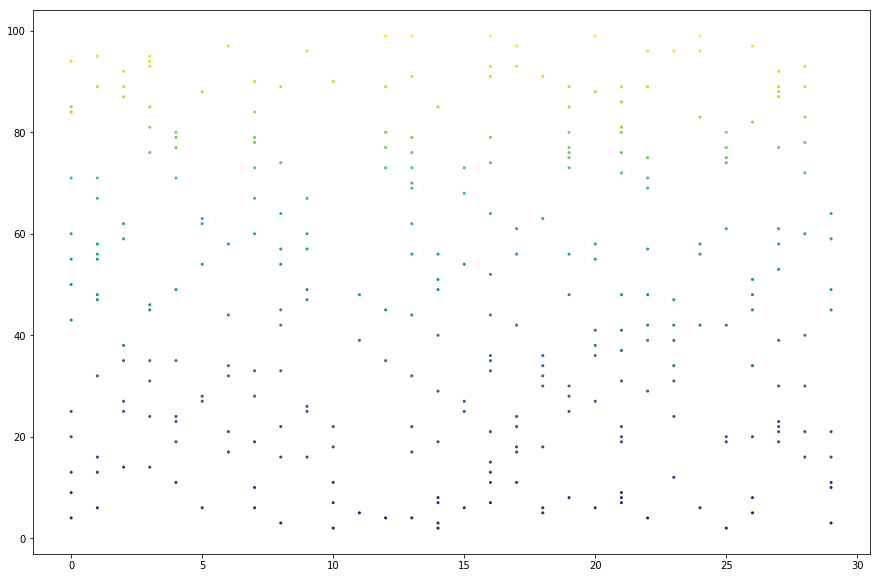

In [30]:



import matplotlib.cm as cm
plt.figure(figsize=[15,10])
colors_map=cm.viridis(np.linspace(0,1,z.shape[0]))
for t in range(z.shape[1]):
    cross=np.argwhere(z[:,t])
    plt.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=4)
    